In [1]:
from aicsimageio import AICSImage
import stackview
import skimage
from skimage.measure import label
from skimage.segmentation import clear_border
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import roifile
import os
from typing import List, Tuple

In [2]:
data_name = "StemCells2785FRAP_3"
file_path = "Z:\\SK\\ReSaved\\" + data_name + "\\" + data_name + "_MMStack_Pos0.ome.tif"
roi_path = "Z:\\SK\\ReSaved\\" + data_name + "RoiSet.zip"

In [3]:
img = AICSImage(file_path)
metadata = img.metadata
delta_t = metadata.images[0].pixels.time_increment
delta_x = metadata.images[0].pixels.physical_size_x
delta_y = metadata.images[0].pixels.physical_size_y
img.shape

(200, 1, 1, 2048, 2048)

In [4]:
# data is returned as a 5d array in the shape t, c, z, x, y.  Since we do not have c or z, remove them here cheaply
img_data = np.squeeze(img.data, axis=(1, 2))
stackview.slice(img_data, slice_number=200, zoom_factor=0.3, continuous_update=True)

In [5]:
def read_imagej_rois(file_path):
    """
    Reads ImageJ ROI files (.roi or .zip) and extracts ROI information,
    including x, y coordinates.

    Args:
        file_path (str): The path to the ImageJ ROI file (e.g., 'my_rois.roi'
                         or 'my_rois.zip').

    Returns:
        list of dict: A list where each dictionary represents an ROI.
                      Each dictionary contains at least 'label' and 'coordinates'.
                      The structure of 'coordinates' depends on the ROI type.
                      Returns an empty list if no ROIs are found or file is invalid.
    """
    roi_data = []

    try:
        # roifile.ImagejRoi.fromfile() is the correct method for reading a single .roi file.
        # For .zip files, it correctly detects and returns a list of ROI objects.
        # This simplifies the initial reading step significantly.
        rois = roifile.ImagejRoi.fromfile(file_path)

        # Ensure 'rois' is always a list for consistent processing
        if not isinstance(rois, list):
            rois = [rois] # Wrap single ROI object in a list

        for roi_obj in rois:
            coords = get_roi_coordinates(roi_obj)
            if coords is not None:
                # Use roi_obj.name for label, fallback if name is not explicitly set
                label = roi_obj.name if roi_obj.name else f"ROI_{rois.index(roi_obj) + 1}"
                # If it's a single .roi file and no name, use filename without extension
                if not roi_obj.name and len(rois) == 1:
                    label = os.path.basename(file_path).replace('.roi', '')

                roi_data.append({
                    'label': label,
                    'roi_type': roi_obj.roitype.name, # Use .name for string representation
                    'coordinates': coords
                })

    except Exception as e:
        print(f"An error occurred while reading {file_path}: {e}")
        return []

    return roi_data

def get_roi_coordinates(roi_obj):
    """
    Extracts coordinates from a roifile.ImagejRoi object based on its type.

    Args:
        roi_obj (roifile.ImagejRoi): An ROI object read by roifile.

    Returns:
        numpy.ndarray or None: A NumPy array of (x, y) coordinates for polygon,
                               freehand, line, or point ROIs.
                               For rectangular or oval ROIs, it returns the bounding box.
                               Returns None for unsupported ROI types or if coordinates are not applicable.
    """
    roi_type = roi_obj.roitype

    if roi_type in [roifile.ROI_TYPE.POLYGON, 
                    roifile.ROI_TYPE.FREELINE, roifile.ROI_TYPE.POINT]:
        # For polygon, freehand, freehandline, and point, the 'points' attribute contains vertices
        # Or, the roi_obj itself can be iterated if it's a point ROI.
        # The coordinates() method is generally the way to get geometric points.
        return roi_obj.coordinates()
    elif roi_type in [roifile.ROI_TYPE.RECT, roifile.ROI_TYPE.OVAL]:
        # Rectangular/Oval ROI: defined by bounding box [left, top, right, bottom]
        # Coordinates can be represented as top-left and bottom-right corners
        return np.array([[roi_obj.left, roi_obj.top],
                         [roi_obj.right, roi_obj.bottom]])
    elif roi_type == roifile.ROI_TYPE.LINE:
        # Line ROI: x1, y1, x2, y2
        return np.array([[roi_obj.x1, roi_obj.y1],
                         [roi_obj.x2, roi_obj.y2]])
    else:
        print(f"Warning: ROI type '{roi_type.name}' ({roi_type}) not explicitly handled for coordinate extraction. "
              "Check roifile documentation for how to access its specific data. ROI Label: {roi_obj.name}")
        return None
        


In [6]:
def create_circular_mask(shape: Tuple[int, int], center: Tuple[int, int], radius: float) -> np.ndarray:
    """
    Create a circular mask for the given shape and center coordinates.
    
    Args:
        shape: Shape of the image (height, width)
        center: Center coordinates (x, y)
        radius: Radius of the circle
    
    Returns:
        Boolean mask where True indicates pixels inside the circle
    """
    y, x = np.ogrid[:shape[0], :shape[1]]
    cx, cy = center
    
    # Calculate distance from center
    distance = np.sqrt((x - cx)**2 + (y - cy)**2)
    
    # Create circular mask
    mask = distance <= radius
    return mask

def extract_circular_intensities(image: np.ndarray, coordinates: List[Tuple[int, int]], 
                               radius: float = 5.0) -> np.ndarray:
    """
    Extract mean intensities from circular regions around given coordinates.
    
    Args:
        image: 3D numpy array of shape (t, x, y)
        coordinates: List of (x, y) coordinate tuples
        radius: Radius of the circular region
    
    Returns:
        2D numpy array of shape (n_coordinates, n_timepoints) containing mean intensities
    """
    n_timepoints, height, width = image.shape
    n_coords = len(coordinates)
    
    # Initialize result array
    intensities = np.zeros((n_coords, n_timepoints))
    
    # Process each coordinate
    for coord_idx, (x, y) in enumerate(coordinates):
        # Check if coordinates are within image bounds
        if x < 0 or x >= width or y < 0 or y >= height:
            print(f"Warning: Coordinate ({x}, {y}) is outside image bounds")
            intensities[coord_idx, :] = np.nan
            continue
        
        # Create circular mask
        mask = create_circular_mask((height, width), (x, y), radius)
        
        # Check if mask contains any pixels
        if not np.any(mask):
            print(f"Warning: No pixels found in circle at ({x}, {y}) with radius {radius}")
            intensities[coord_idx, :] = np.nan
            continue
        
        # Extract mean intensity for each time point
        for t in range(n_timepoints):
            masked_pixels = image[t][mask]
            intensities[coord_idx, t] = np.mean(masked_pixels)
    
    return intensities

def plot_intensity_timeseries(intensities: np.ndarray, coordinates: List[Tuple[int, int]], 
                            radius: float, time_interval: float = 1.0, figsize: Tuple[int, int] = (12, 8)):
    """
    Plot intensity time series for each coordinate, normalized by the first time point.
    
    Args:
        intensities: 2D array of shape (n_coordinates, n_timepoints)
        coordinates: List of (x, y) coordinate tuples
        radius: Radius used for extraction
        time_interval: Time interval between data points in seconds
        figsize: Figure size tuple
    """
    n_coords, n_timepoints = intensities.shape
    time_points = np.arange(n_timepoints) * time_interval
    
    plt.figure(figsize=figsize)
    
    # Plot each coordinate's time series
    for i, (x, y) in enumerate(coordinates):
        # Normalize by the first time point
        first_point = intensities[i, 0]
        if not np.isnan(first_point) and first_point != 0:
            normalized_intensities = intensities[i, :] / first_point
        else:
            # Handle edge case where first point is NaN or zero
            normalized_intensities = np.full_like(intensities[i, :], np.nan)
            
        plt.plot(time_points, normalized_intensities, 
                marker='o', markersize=3, linewidth=1.5,
                label=f'({x}, {y})')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Normalized Intensity (F/F₀)')
    plt.title(f'Normalized Intensity Time Series (Radius: {radius})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def analyze_circular_regions(image: np.ndarray, coordinates: List[Tuple[int, int]], 
                           radius: float = 5.0, time_interval: float = 1.0, plot: bool = True) -> np.ndarray:
    """
    Complete analysis pipeline: extract intensities and optionally plot results.
    
    Args:
        image: 3D numpy array of shape (t, x, y)
        coordinates: List of (x, y) coordinate tuples
        radius: Radius of the circular region
        time_interval: Time interval between data points in seconds
        plot: Whether to create a plot
    
    Returns:
        2D numpy array of intensities
    """
    print(f"Analyzing {len(coordinates)} coordinates with radius {radius}")
    print(f"Image shape: {image.shape}")
    
    # Extract intensities
    intensities = extract_circular_intensities(image, coordinates, radius)
    
    # Print summary statistics
    print(f"\nIntensity Statistics:")
    print(f"Shape: {intensities.shape}")
    print(f"Mean across all: {np.nanmean(intensities):.3f}")
    print(f"Std across all: {np.nanstd(intensities):.3f}")
    print(f"Min: {np.nanmin(intensities):.3f}")
    print(f"Max: {np.nanmax(intensities):.3f}")
    
    # Plot if requested
    if plot:
        plot_intensity_timeseries(intensities, coordinates, radius, time_interval)
    
    return intensities


[(980, 1038), (1114, 944), (1139, 914), (1200, 936), (1189, 1001), (1117, 1071)]
Analyzing 6 coordinates with radius 10.0
Image shape: (200, 2048, 2048)

Intensity Statistics:
Shape: (6, 200)
Mean across all: 407.680
Std across all: 257.997
Min: 178.577
Max: 2769.013


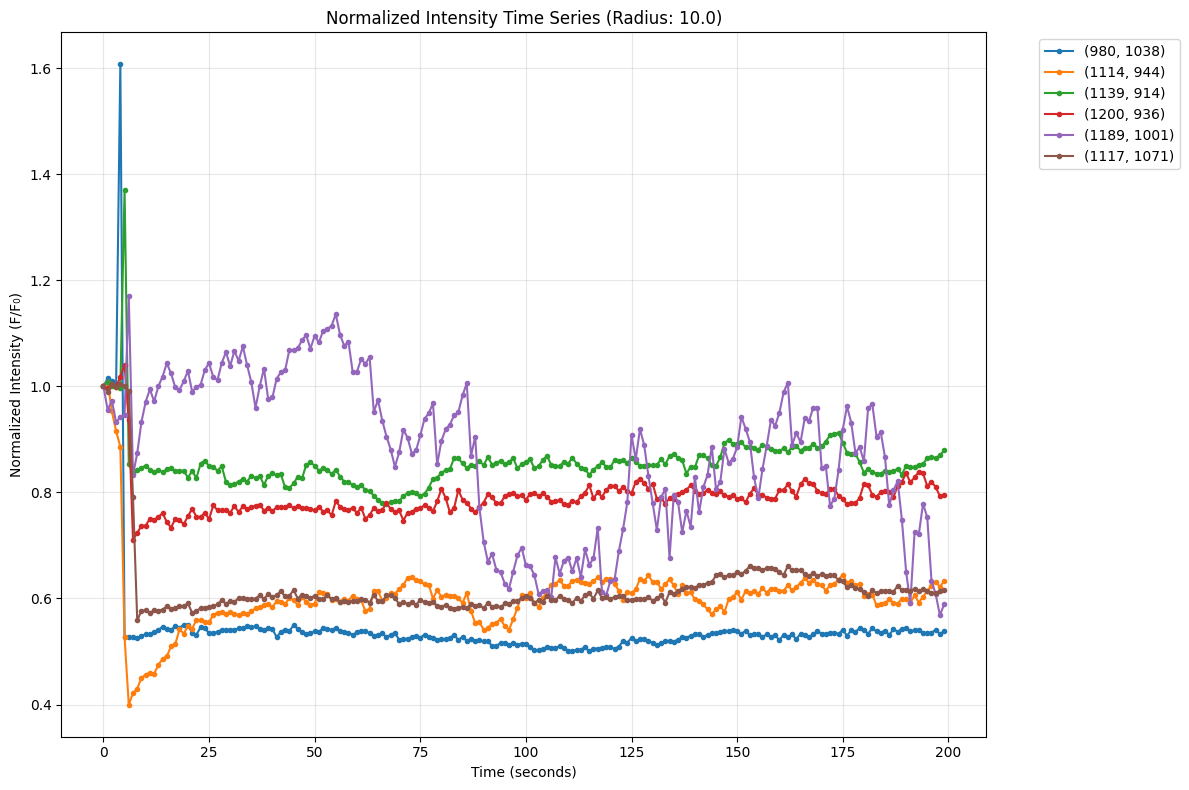


First coordinate time series (first 10 points):
[1723.04100946 1748.7444795  1740.96845426 1729.13249211 2769.0126183
  909.2807571   910.18611987  907.          905.21135647  911.31230284]


In [17]:
rois = read_imagej_rois(roi_path)
coordinates = []
for roi in rois:
    coordinates.append((int(roi['coordinates'][0][0]), int(roi['coordinates'][0][1])))
# Add an equal number of control points
#for roi in rois:
#    coordinates.append((int(roi['coordinates'][0][0] + 30), int(roi['coordinates'][0][1] + 30)))
print (coordinates)

# Run analysis
intensities = analyze_circular_regions(img_data, coordinates, radius=10.0, time_interval= delta_t / 1000)  # Read from Image metadata)
    
# You can also access individual time series
print(f"\nFirst coordinate time series (first 10 points):")
print(intensities[0, :10])